In [1]:
sc

In [2]:
raw_data = sc.textFile('/home/simon/School/STK-INF4000/Project/Data/merged_data.csv')

In [3]:
fields = raw_data.filter(lambda line: line.startswith(',S')).take(1)[0].split(',')[1:]
fields

[u'Start station', u'Start time', u'End station', u'End time']

In [4]:
from datetime import datetime

def ymd_hm(datestr):
    try:
        return datetime.strptime(datestr, '%Y-%m-%d %H:%M:%S')
    except ValueError:
        return None

In [5]:
(raw_data.filter(lambda line: not line.startswith(',S'))
 .map(lambda x: x.split(',')[1:])
 .map(lambda (startstation, starttime, endstation, endtime) : (int(float(startstation)), ymd_hm(starttime[:-6])))).take(10)

[(227, datetime.datetime(2016, 4, 1, 7, 15, 4)),
 (267, datetime.datetime(2016, 4, 1, 7, 22, 36)),
 (302, datetime.datetime(2016, 4, 1, 9, 3, 43)),
 (202, datetime.datetime(2016, 4, 1, 9, 53, 28)),
 (202, datetime.datetime(2016, 4, 1, 9, 54, 38)),
 (210, datetime.datetime(2016, 4, 1, 12, 48, 47)),
 (243, datetime.datetime(2016, 4, 1, 13, 7, 6)),
 (243, datetime.datetime(2016, 4, 1, 13, 7, 37)),
 (181, datetime.datetime(2016, 4, 1, 13, 10, 20)),
 (160, datetime.datetime(2016, 4, 1, 13, 47, 37))]

In [6]:
dates = (raw_data.filter(lambda line: not line.startswith(',S'))
 .map(lambda x: x.split(',')[1:])
 .map(lambda (startstation, starttime, endstation, endtime) : ymd_hm(starttime[:-6])))

In [7]:
dates.take(15)

[datetime.datetime(2016, 4, 1, 7, 15, 4),
 datetime.datetime(2016, 4, 1, 7, 22, 36),
 datetime.datetime(2016, 4, 1, 9, 3, 43),
 datetime.datetime(2016, 4, 1, 9, 53, 28),
 datetime.datetime(2016, 4, 1, 9, 54, 38),
 datetime.datetime(2016, 4, 1, 12, 48, 47),
 datetime.datetime(2016, 4, 1, 13, 7, 6),
 datetime.datetime(2016, 4, 1, 13, 7, 37),
 datetime.datetime(2016, 4, 1, 13, 10, 20),
 datetime.datetime(2016, 4, 1, 13, 47, 37),
 datetime.datetime(2016, 4, 1, 14, 18, 3),
 datetime.datetime(2016, 4, 1, 14, 41, 36),
 datetime.datetime(2016, 4, 1, 14, 41, 43),
 datetime.datetime(2016, 4, 1, 14, 41, 53),
 datetime.datetime(2016, 4, 1, 14, 50, 14)]

In [8]:
from operator import add

In [9]:
whole_hours = dates.map(lambda x: datetime(x.year, x.month, x.day, x.hour))

In [10]:
whole_hours.take(5)

[datetime.datetime(2016, 4, 1, 7, 0),
 datetime.datetime(2016, 4, 1, 7, 0),
 datetime.datetime(2016, 4, 1, 9, 0),
 datetime.datetime(2016, 4, 1, 9, 0),
 datetime.datetime(2016, 4, 1, 9, 0)]

In [11]:
hourly_counts = whole_hours.map(lambda x: (x, 1)).reduceByKey(add)

In [12]:
hourly_counts.take(5)

[(datetime.datetime(2016, 8, 7, 15, 0), 582),
 (datetime.datetime(2016, 7, 15, 6, 0), 201),
 (datetime.datetime(2016, 9, 18, 10, 0), 297),
 (datetime.datetime(2016, 4, 28, 18, 0), 663),
 (datetime.datetime(2016, 11, 12, 20, 0), 90)]

In [13]:
min_date, max_date = whole_hours.min(), whole_hours.max()

In [14]:
min_date, max_date

(datetime.datetime(2016, 4, 1, 7, 0), datetime.datetime(2016, 12, 5, 23, 0))

In [15]:
from datetime import timedelta 

hours = [min_date]
while hours[-1] < max_date:
    hours.append(hours[-1] + timedelta(hours=1))

In [16]:
all_hours = sc.parallelize(((d, 0) for d in hours))

In [17]:
all_hours.take(5)

[(datetime.datetime(2016, 4, 1, 7, 0), 0),
 (datetime.datetime(2016, 4, 1, 8, 0), 0),
 (datetime.datetime(2016, 4, 1, 9, 0), 0),
 (datetime.datetime(2016, 4, 1, 10, 0), 0),
 (datetime.datetime(2016, 4, 1, 11, 0), 0)]

In [18]:
full_counts = all_hours.leftOuterJoin(hourly_counts)

In [19]:
full_counts = all_hours.leftOuterJoin(hourly_counts)

In [20]:
full_counts = all_hours.leftOuterJoin(hourly_counts).map(lambda (k, v): (k, max(v))).cache()

In [21]:
full_counts.take(5)

[(datetime.datetime(2016, 6, 28, 11, 0), 472),
 (datetime.datetime(2016, 11, 5, 4, 0), 0),
 (datetime.datetime(2016, 12, 3, 19, 0), 157),
 (datetime.datetime(2016, 8, 29, 11, 0), 468),
 (datetime.datetime(2016, 9, 9, 14, 0), 801)]

In [22]:
lags = (timedelta(hours=1), timedelta(days=1), timedelta(days=7), timedelta(days=28))

In [23]:
data = full_counts.map(lambda (d, c): (d, (c,)))

In [24]:
for lag in lags:
    data = (data
           .join(full_counts.map(lambda (d, c): (d + lag, c)))
           .map(lambda (d, (t, v)): (d, t + (v,))))

In [25]:
data.take(5)

[(datetime.datetime(2016, 7, 22, 19, 0), (790, 855, 309, 694, 675)),
 (datetime.datetime(2016, 5, 7, 8, 0), (132, 78, 634, 101, 53)),
 (datetime.datetime(2016, 10, 22, 14, 0), (437, 395, 526, 448, 772)),
 (datetime.datetime(2016, 11, 29, 21, 0), (191, 228, 169, 188, 191)),
 (datetime.datetime(2016, 9, 6, 15, 0), (1085, 775, 1176, 1074, 552))]

In [26]:
from pyspark.ml.linalg import Vectors

In [27]:
from pyspark.sql import Row

X = spark.createDataFrame(data.map(lambda (d, v): Row(date=d,
                                                      features=Vectors.dense(v[1:]),
                                                      label=v[0])))

In [28]:
X.show(5)

+--------------------+--------------------+-----+
|                date|            features|label|
+--------------------+--------------------+-----+
|2016-07-22 19:00:...|[855.0,309.0,694....|  790|
|2016-05-07 08:00:...|[78.0,634.0,101.0...|  132|
|2016-10-22 14:00:...|[395.0,526.0,448....|  437|
|2016-11-29 21:00:...|[228.0,169.0,188....|  191|
|2016-09-06 15:00:...|[775.0,1176.0,107...| 1085|
+--------------------+--------------------+-----+
only showing top 5 rows



In [29]:
from pyspark.ml.regression import DecisionTreeRegressor

In [49]:
split_point = datetime(2016, 8, 31)
Xtr = X.filter(X.date < split_point)
Xte = X.filter(X.date >= split_point)

In [50]:
depths = range(2, 20, 2)

In [51]:
models = [DecisionTreeRegressor(maxDepth=d).fit(Xtr) for d in depths]

In [52]:
p = models[5].transform(Xte)

In [53]:
p.show(5)

+--------------------+--------------------+-----+----------+
|                date|            features|label|prediction|
+--------------------+--------------------+-----+----------+
|2016-10-22 14:00:...|[395.0,526.0,448....|  437|    501.75|
|2016-11-29 21:00:...|[228.0,169.0,188....|  191|     229.0|
|2016-09-06 15:00:...|[775.0,1176.0,107...| 1085|    978.75|
|2016-11-30 15:00:...|[259.0,331.0,422....|  405|     348.5|
|2016-11-14 07:00:...|[103.0,38.0,0.0,5...|  274|     144.0|
+--------------------+--------------------+-----+----------+
only showing top 5 rows



In [54]:
import pyspark.sql.functions as fn

In [55]:
def get_mse(RDD):
    mse_df = RDD.agg(fn.mean((RDD.label - RDD.prediction)**2).alias('mse'))
    return mse_df.collect()[0].mse

In [56]:
mses = [get_mse(model.transform(Xte)) for model in models]

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

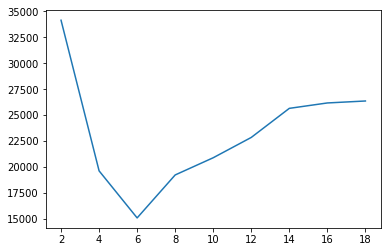

In [58]:
plt.plot(depths, mses)

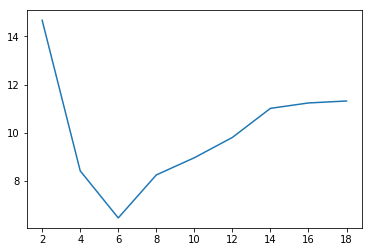

In [59]:
# Plot Mses on the right scale
n_test_cases = Xte.count()
mses_on_right_scale = [get_mse(model.transform(Xte))/n_test_cases for model in models]
plt.plot(depths, mses_on_right_scale)

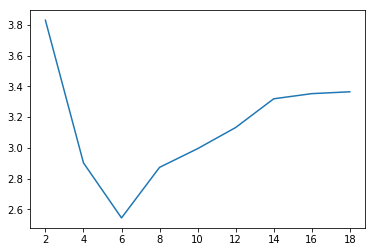

In [60]:
import numpy as np
# Plot rootMses on the right scale
mses_on_right_scale = [np.sqrt(get_mse(model.transform(Xte))/n_test_cases) for model in models]
plt.plot(depths, mses_on_right_scale)

In [69]:
best_model = models[depths.index(6)]
# MSE, total
print get_mse(best_model.transform(Xte))
# MSE
print get_mse(best_model.transform(Xte))/n_test_cases
# rMSE
print np.sqrt(get_mse(best_model.transform((Xte)))/n_test_cases)


15070.3942873
6.47353706497
2.54431465526


In [62]:
df = best_model.transform(Xte).toPandas()

In [63]:
df = df.set_index('date').sort_index()

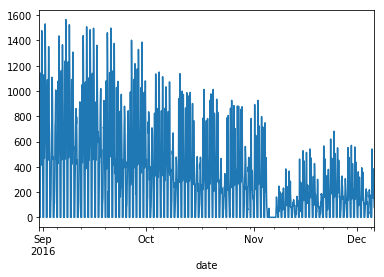

In [64]:
df.label.plot()

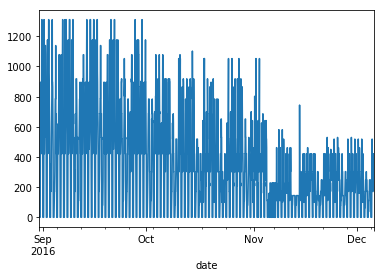

In [65]:
df.prediction.plot()

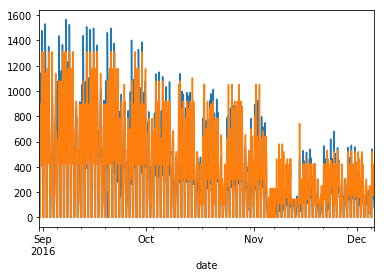

In [66]:
df.label.plot()
df.prediction.plot()